# 패키지

In [1]:
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
import gc

# 데이터

In [2]:
default_path = 'C:/Users/ebdl/'

In [3]:
train = pd.read_csv(default_path+'data_v2/weekly_train.csv')
test = pd.read_csv(default_path+'data_v2/public_weekly_test.csv')

In [4]:
train.head()

,week_start,week_file_nm,data_list
0,1978-10-23,10000.npy,"19781026.npy,19781028.npy"
1,1978-10-30,10001.npy,"19781030.npy,19781101.npy,19781103.npy,1978110..."
2,1978-11-06,10002.npy,"19781107.npy,19781109.npy,19781111.npy"
3,1978-11-13,10003.npy,"19781113.npy,19781115.npy,19781117.npy,1978111..."
4,1978-11-20,10004.npy,"19781121.npy,19781123.npy,19781125.npy"


In [5]:
test.tail()

,week_start,week_file_nm,data_list
19,2020-05-18,12169.npy,"20200518.npy,20200519.npy,20200520.npy,2020052..."
20,2020-05-25,12170.npy,"20200525.npy,20200526.npy,20200527.npy,2020052..."
21,2020-06-01,12171.npy,"20200601.npy,20200602.npy,20200603.npy,2020060..."
22,2020-06-08,12172.npy,"20200608.npy,20200609.npy,20200610.npy,2020061..."
23,2020-06-15,12173.npy,"20200615.npy,20200616.npy,20200617.npy,2020061..."


# 시각화 & 전처리

최근 약 30년(52주 * 30년) 주별 데이터만을 사용하였습니다.

In [6]:
# 최근 52주 데이터 파일 이름을 가져오고 .values 속성을 사용하여 Numpy 배열로 변환합니다.
train_data_path = 'data_v2/weekly_train/'+train.tail(52*30)['week_file_nm'].values

In [7]:
sample = np.load(train_data_path[-1])

각 파일은 5개 채널의 배열로 구성되어있습니다.
1. 해빙 농도(0~250)
2. 북극점(위성 관측 불가 영역)
3. 해안선 마스크
4. 육지 마스크
5. 결측값 


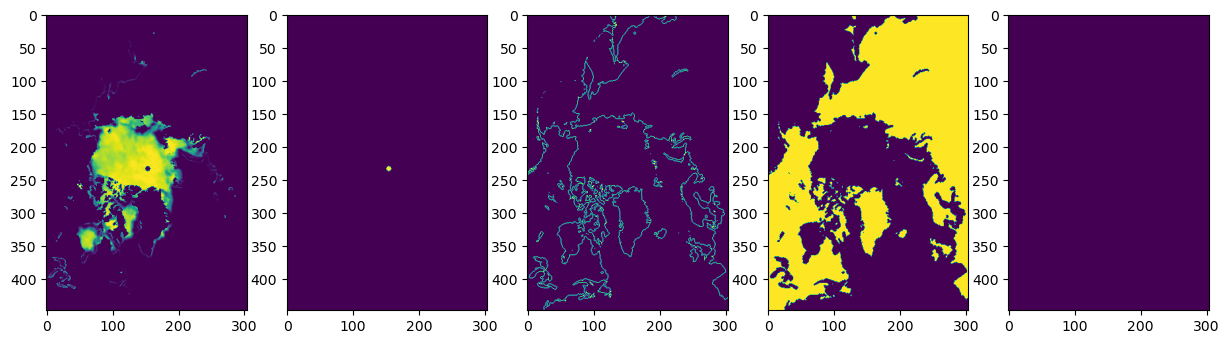

In [8]:
"""
해빙/북극점/해안/지면/결측치

"""
plt.figure(figsize=(15,5))
for c in range(sample.shape[-1]):
    plt.subplot(1,5,c+1)
    plt.imshow(sample[:,:,c])
plt.show()

테스트 활용 가능 마지막 제공 데이터와 맞춰야하는 기간 사이에는 2주의 공백이 있습니다.

과거 12주의 해빙 변화를 보고 2주 뒤부터 12주간 의 변화르 예측하는 모델을 만들겠습니다.

In [9]:
input_window_size = 12
target_window_size = 12
gap = 2
step = 1
input_data_list, target_data_list = [], []

# for i in range(0, 종료인덱스, step)
for i in range(0, len(train_data_path)-input_window_size-target_window_size-gap+1, step):
    input_data = train_data_path[i:i+input_window_size]
    target_data = train_data_path[i+input_window_size+gap:i+input_window_size+gap+target_window_size]
    input_data_list.append(input_data)
    target_data_list.append(target_data)

In [10]:
input_data_list[-1]

array(['data_v2/weekly_train/12200.npy', 'data_v2/weekly_train/12201.npy',
       'data_v2/weekly_train/12202.npy', 'data_v2/weekly_train/12203.npy',
       'data_v2/weekly_train/12204.npy', 'data_v2/weekly_train/12205.npy',
       'data_v2/weekly_train/12206.npy', 'data_v2/weekly_train/12207.npy',
       'data_v2/weekly_train/12208.npy', 'data_v2/weekly_train/12209.npy',
       'data_v2/weekly_train/12210.npy', 'data_v2/weekly_train/12211.npy'],
      dtype=object)

In [11]:
target_data_list[-1]

array(['data_v2/weekly_train/12214.npy', 'data_v2/weekly_train/12215.npy',
       'data_v2/weekly_train/12216.npy', 'data_v2/weekly_train/12217.npy',
       'data_v2/weekly_train/12218.npy', 'data_v2/weekly_train/12219.npy',
       'data_v2/weekly_train/12220.npy', 'data_v2/weekly_train/12221.npy',
       'data_v2/weekly_train/12222.npy', 'data_v2/weekly_train/12223.npy',
       'data_v2/weekly_train/12224.npy', 'data_v2/weekly_train/12225.npy'],
      dtype=object)

## 데이터셋

학습과 검증용 데이터로 분리합니다.

최근 1년(52주)을 검증 데이터셋으로 사용하였습니다.

In [12]:
def train_map_func(x_list, y_list):
    train_x, train_y = [], []
    for path in x_list:
        # 첫번째 channel만 선택하여 load 합니다.
        train_x.append(np.load(path)[:,:,0:1])
    for path in y_list:
        # 첫번째 channel만 선택하여 load 합니다.
        train_y.append(np.load(path)[:,:,0:1])
        
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    
    train_x = train_x.astype(np.float32)/250
    train_y = train_y.astype(np.float32)/250
    return train_x, train_y

In [13]:
BATCH_SIZE = 2

In [14]:
# 데이터 집합 객체 생성
train_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[:-52], target_data_list[:-52]))

# AUTOTUNE은 사용 가능한 메모리 양에 맞춰 버퍼 크기를 동적으로 조정합니다.
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[-52:], target_data_list[-52:]))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]),
 TensorShape([2, 12, 448, 304, 1]))

# 모델

ConvLSTMCell을 이용하여 Seq2Seq모델을 만들었습니다.

## ConvLSTMCell

In [16]:
class ConvLSTMCell(tf.keras.Model):
    # 클래스 정의
    def __init__(self, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.kernel_size = kernel_size
        self.bias = bias
        
        # 핉터 수의 4배를 갖는 2D 컨볼루션 레이어 정의
        self.conv = tf.keras.layers.Conv2D(
            filters = 4 * self.hidden_dim,
            kernel_size = self.kernel_size,
            padding = 'same',
            use_bias = self.bias
        )
        
        
    # input_tensor와 현재 은닉,셀 상태를 입력으로 받음
    def call(self, input_tensor, cur_state):       
        h_cur, c_cur = cur_state
        
        # 깊이 차원을 따라 concat
        combined = tf.concat([input_tensor, h_cur], axis=3) 
        
        # __init__에 정의된 conv 레이어를 통과합니다.
        combined_conv = self.conv(combined)
        
        # 통과한 텐서는 4개의 부분으로 분할합니다.
        cc_i, cc_f, cc_o, cc_g = tf.split(combined_conv, num_or_size_splits=4, axis=-1)
        
        # 각각 활성화 함수를 통과
        i = tf.keras.activations.sigmoid(cc_i)
        f = tf.keras.activations.sigmoid(cc_f)
        o = tf.keras.activations.sigmoid(cc_o)
        g = tf.keras.activations.tanh(cc_g)
        
        # 은닉, 셀 상태 업데이트
        c_next = f*c_cur+i*g
        h_next = o*tf.keras.activations.tanh(c_next)
        
        return h_next, c_next
        
        
    # 은닉, 셀 상태를 0으로 초기화하는 메서드
    def init_hidden(self, batch_size, image_size):
        height, width = image_size    # 높이와 너비는 image_size에서 가져옵니다.
        return (tf.zeros([batch_size, height, width, self.hidden_dim]),
                tf.zeros([batch_size, height, width, self.hidden_dim]))

## Encoder

In [17]:
class Encoder(tf.keras.Model):
    """
    def __init__(self, hidden, enc_num_layers=1):
    
    입력으로 hidden 크기와 enc_num_layers(숨겨진 레이어의 수)를 받습니다.
    ConvLSTMCell을 사용하여 encoder_input_convlstm 셀을 초기화합니다.
    
    enc_num_layers가 None이 아니면, hidden_encoder_layers 리스트에 
    ConvLSTMCell을 enc_num_layers 개수만큼 생성합니다.
    
    """
    def __init__(self, hidden, enc_num_layers=1):
        super(Encoder, self).__init__()
        self.enc_num_layers = enc_num_layers
        self.encoder_input_convlstm = ConvLSTMCell
        (
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.enc_num_layers is not None:
            self.hidden_encoder_layers = 
            [
                ConvLSTMCell
                (
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(self.enc_num_layers)
            ]
            
            
        
    """
    def call(self, enc_input):
    
    Encoder 클래스의 forward 연산 함수입니다.
    입력으로 enc_input을 받습니다.
    init_hidden 함수를 사용하여 초기 숨겨진 상태(h_t)와 셀 상태(c_t)를 초기화합니다.
    enc_num_layers가 None이 아니면, hidden_h_t와 hidden_c_t 리스트를 초기화합니다.
    seq_len만큼 반복문을 실행하면서, 입력 데이터를 ConvLSTM 셀에 전달하여 h_t와 c_t를 업데이트합니다.
    
    만약 enc_num_layers가 None이 아니면, hidden_encoder_layers 리스트의 
    모든 ConvLSTM 셀에 대해서 hidden_h_t와 hidden_c_t를 업데이트합니다.
    
    
    """
    def call(self, enc_input):
        h_t, c_t = self.init_hidden(enc_input, 'seq')
        if self.enc_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.enc_num_layers):
                hidden_h_t += [self.init_hidden(h_t, i)[0]]
                hidden_c_t += [self.init_hidden(h_t, i)[1]]
        
        seq_len = enc_input.shape[1]
        for t in range(seq_len):
            h_t, c_t = self.encoder_input_convlstm
            (
                input_tensor=enc_input[:, t, :, :, :],
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            if self.enc_num_layers is not None:
                for i in range(self.enc_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_encoder_layers[i]
                    (
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor = hidden_h_t[i]
        
        if self.enc_num_layers is not None:
            return hidden_h_t[-1], hidden_c_t[-1]  # 마지막, 인덱스값이 가장 큰 hidden and cell state를 반환
        else:
            return h_t, c_t
    
    
    """
    def init_hidden(self, input_tensor, seq):
    
    seq=='seq' 이면 input_tensor가 시퀀스, 아니면 단일 이미지.
    인코더를 통한 포워드 패스 동안 ConvLSTM 셀의 반복적인 업데이트를 
    위한 시작점으로 사용되는 초기 숨겨진 상태와 셀 상태를 반환합니다.
    
    """
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, seq_len, h, w, _ = input_tensor.shape  # 배치크기, 시퀀스 길이, 높이, 너비
            h_t, c_t = self.encoder_input_convlstm.init_hidden
            (
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape  # 배치크기, 높이, 너비
            h_t, c_t = self.hidden_encoder_layers[seq].init_hidden
            (
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [18]:
# 다음 입력 데이터 배치를 검색합니다.
sample_enc_input_data = next(iter(train_dataset))[0]

# hidden size=16, layer=1
sample_encoder = Encoder(16, 1)
enc_output = sample_encoder(sample_enc_input_data)
enc_output[0].shape, enc_output[1].shape

(TensorShape([2, 448, 304, 16]), TensorShape([2, 448, 304, 16]))

## Decoder

In [19]:
class Decoder(tf.keras.Model):
    """
    생성자에서는 decoder의 hyperparameter로 `hidden`, `dec_num_layers`, `future_len`을 받습니다.
    `dec_num_layers`가 None이 아니면, `hidden_dim`과 `kernel_size`를 갖는 
    ConvLSTMCell들을 `hidden_decoder_layers` 리스트에 저장합니다.
     
    """
    def __init__(self, hidden, dec_num_layers=1, future_len=12):
        super(Decoder, self).__init__()
        self.dec_num_layers = dec_num_layers
        self.future_len = future_len # 시퀀스의 길이
        
        self.decoder_input_convlstm = ConvLSTMCell
        (
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.dec_num_layers is not None:
            self.hidden_decoder_layers = 
            [
                ConvLSTMCell
                (
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(dec_num_layers)
            ]
        
        # 마지막에 출력할 1개의 feature map을 만들기 위한 Conv2D 레이어입니다.
        self.decoder_output_layer = tf.keras.layers.Conv2D
        (
            filters=1,
            kernel_size=(3,3),
            padding='same',
            activation='sigmoid'
        )
        
    """
    `enc_output`을 인자로 받습니다.
    `init_hidden` 메소드를 이용하여, input_tensor의 shape과 `dec_num_layers`를 확인하여 h_t와 c_t를 초기화합니다.
    `future_len`만큼 for loop을 실행하면서 `input_tensor`와 h_t와 c_t를 ConvLSTMCell에 입력하여 다음 state를 계산합니다.
    만약 `dec_num_layers`가 None이 아니라면, `hidden_decoder_layers` 리스트에 저장된 ConvLSTMCell들을 통해 다음 state를 계산합니다.
    계산된 state를 이용하여 `decoder_output_layer`를 통해 출력을 계산하고, `outputs` 리스트에 저장합니다.
    `tf.stack`을 통해 리스트의 요소들을 하나로 합친 다음, 반환합니다.
    
    """
    def call(self, enc_output):
        if self.dec_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.dec_num_layers):
                hidden_h_t += [self.init_hidden(enc_output[0], i)[0]]
                hidden_c_t += [self.init_hidden(enc_output[0], i)[1]]
                
        outputs = []
        input_tensor = enc_output[0]
        h_t, c_t = self.init_hidden(input_tensor, 'seq')
        
        for t in range(self.future_len):
            h_t, c_t=self.decoder_input_convlstm
            (
                input_tensor=input_tensor,
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            
            if self.dec_num_layers is not None:
                for i in range(self.dec_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_decoder_layers[i]
                    (
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor=hidden_h_t[i]
                output = self.decoder_output_layer(hidden_h_t[-1])
            else:
                output = self.decoder_output_layer(h_t)

            outputs += [output]
            
        outputs = tf.stack(outputs, 1) 
        
        return outputs
    
    """
    def init_hidden(self, input_tensor, seq):
    
    seq=='seq' 이면 input_tensor가 시퀀스, 아니면 단일 이미지.
    인코더를 통한 포워드 패스 동안 ConvLSTM 셀의 반복적인 업데이트를 
    위한 시작점으로 사용되는 초기 숨겨진 상태와 셀 상태를 반환합니다.
    
    """
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.decoder_input_convlstm.init_hidden
            (
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.hidden_decoder_layers[seq].init_hidden
            (
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [20]:
sample_decoder = Decoder(16)
dec_output = sample_decoder(enc_output)

# (batch_size, sequence_length, height, width, channels)
dec_output.shape

TensorShape([2, 12, 448, 304, 1])

## Seq2Seq

Encoder와 Decoder를 연결한 최종 모델입니다.

In [21]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, hidden, enc_num_layers=1, dec_num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(hidden, enc_num_layers)
        self.decoder = Decoder(hidden, dec_num_layers)
        
    def call(self, enc_input):
        enc_output = self.encoder(enc_input)
        dec_output = self.decoder(enc_output)
        
        return dec_output

In [22]:
model = Seq2Seq(16, 1, 1)

## 학습률 & 옵티마이저

In [23]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 손실 함수

손실함수로 MAE를 사용하였습니다.

In [24]:
@tf.function
def loss_function(output, target):
    mae_loss = tf.math.reduce_mean(tf.keras.losses.MAE(output, target))
    return mae_loss

## 대회 산식(MAE / F1)

검증용으로 사용하였습니다.

In [25]:
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    return score

def f1_score(true, pred):
    target = np.where((true > 0.05) & (true < 0.5))
    
    true = true[target]
    pred = pred[target]
    
    true = np.where(true < 0.15, 0, 1)
    pred = np.where(pred < 0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true + 1e-8)
    recall = right / np.sum(pred + 1e-8)

    score = 2 * precision * recall / (precision + recall + 1e-8)
    
    return score

def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1 + 1e-8)
    
    return score

def val_score(inp, targ):
    output = model(inp)
    score = mae_over_f1(targ.numpy(), output.numpy())
    return score

## 학습 정의

In [26]:
@tf.function
def train_step(inp, targ, training):
    # 입력데이터와 정답데이터 사이의 손실을 계산
    loss = 0
    with tf.device("/device:GPU:0"):
        with tf.GradientTape() as tape:
            output = model(inp)
            for t in range(targ.shape[1]):
                loss += loss_function(targ[:, t], output[:, t])

        batch_loss = (loss / int(targ.shape[1]))

        if training==True:
            variables = model.trainable_variables
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [27]:
gc.collect()

0

## 체크포인트

In [30]:
checkpoint_path = './checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(
    Seq2Seq=model, 
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [31]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

## 학습

In [32]:
EPOCHS = 50

loss_plot, val_score_plot = [], []
with tf.device("/device:GPU:0"):
    for epoch in range(EPOCHS):
        total_loss, total_val_score = 0, 0

        tqdm_dataset = tqdm(enumerate(train_dataset))
        for (batch, (inp, targ)) in tqdm_dataset:
            batch_loss = train_step(inp, targ, True)
            total_loss += batch_loss

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(250*batch_loss.numpy().mean()),
                'Total Loss' : '{:06f}'.format(250*total_loss/(batch+1))
            })
        loss_plot.append(250*total_loss/(batch+1))

        tqdm_dataset_val = tqdm(enumerate(val_dataset))
        for (batch, (inp, targ)) in tqdm_dataset_val:
            batch_val_score = val_score(inp, targ)
            total_val_score += batch_val_score.mean()

            tqdm_dataset_val.set_postfix({
                'Epoch': epoch + 1,
                'Val Score': '{:06f}'.format(250*batch_val_score.mean()),
                'Val Total_Score' : '{:06f}'.format(250*total_val_score/(batch+1))
            })
        val_score_plot.append(250*total_val_score/(batch+1))

        if np.min(val_score_plot) == val_score_plot[-1]:
            ckpt_manager.save()

742it [07:24,  1.67it/s, Epoch=1, Loss=11.811262, Total Loss=17.978580] 
26it [00:19,  1.33it/s, Epoch=1, Val Score=16.051315, Val Total_Score=82.354119]  
742it [07:26,  1.66it/s, Epoch=2, Loss=10.093888, Total Loss=11.240512]
26it [00:06,  4.33it/s, Epoch=2, Val Score=13.751910, Val Total_Score=38.418405] 
742it [07:22,  1.68it/s, Epoch=3, Loss=9.377947, Total Loss=10.615611] 
26it [00:06,  4.31it/s, Epoch=3, Val Score=12.562909, Val Total_Score=34.836393] 
742it [07:20,  1.68it/s, Epoch=4, Loss=8.850155, Total Loss=10.129323] 
26it [00:05,  4.42it/s, Epoch=4, Val Score=11.759242, Val Total_Score=32.111632] 
742it [07:16,  1.70it/s, Epoch=5, Loss=8.464362, Total Loss=9.792014] 
26it [00:06,  4.27it/s, Epoch=5, Val Score=10.918225, Val Total_Score=30.366481] 
742it [07:26,  1.66it/s, Epoch=6, Loss=8.357543, Total Loss=9.355567] 
26it [00:06,  4.33it/s, Epoch=6, Val Score=10.723886, Val Total_Score=31.297573] 
742it [07:19,  1.69it/s, Epoch=7, Loss=7.957350, Total Loss=8.975765] 
26it 

## 학습 결과

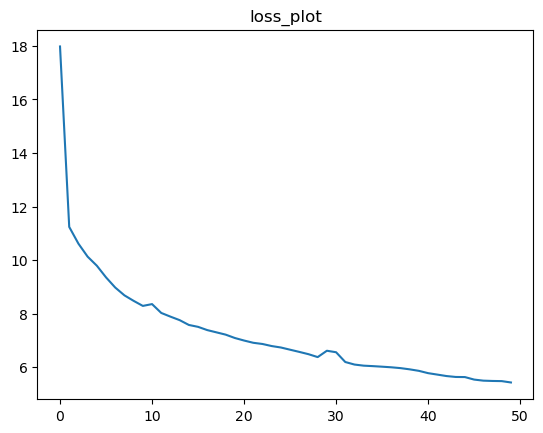

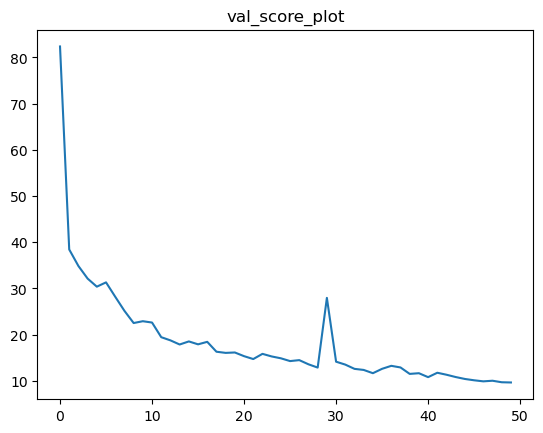

In [33]:
plt.plot(loss_plot)
plt.title('loss_plot')
plt.show()

plt.plot(val_score_plot)
plt.title('val_score_plot')
plt.show()

## 모델복원

In [34]:
ckpt.restore(ckpt_manager.latest_checkpoint)

## 추론
- 새로운 입력 데이터에 대한 출력을 생성

In [39]:
test = pd.read_csv('data_v2//public_weekly_test.csv')
test_path = './data_v2/weekly_train/'+test.tail(12)['week_file_nm']

In [40]:
def predict(img_path):
    test_imgs=[]
    for path in img_path:
        test_imgs.append(np.load(path)[:,:,0:1].astype(np.float32)/250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = model(enc_input)[0].numpy()*250
    
    return pred

In [41]:
pred = predict(test_path)

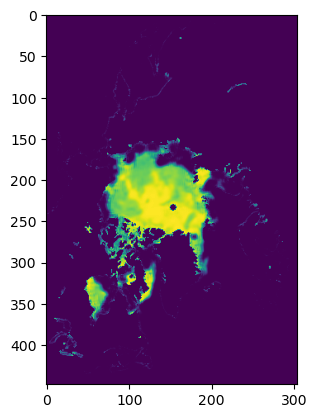

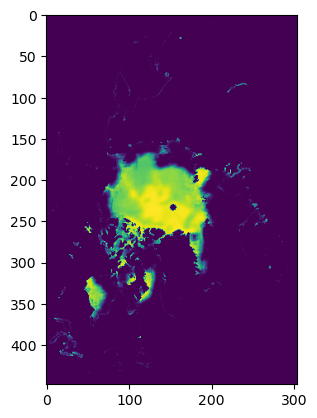

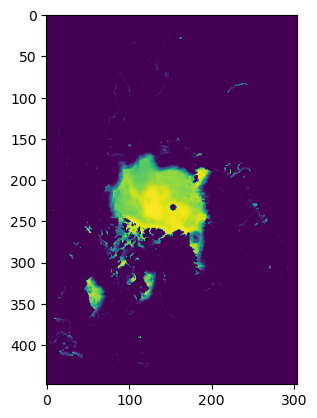

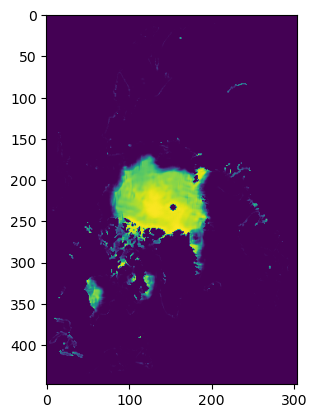

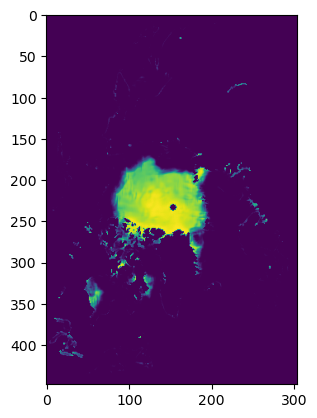

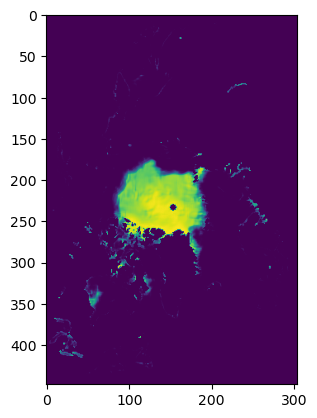

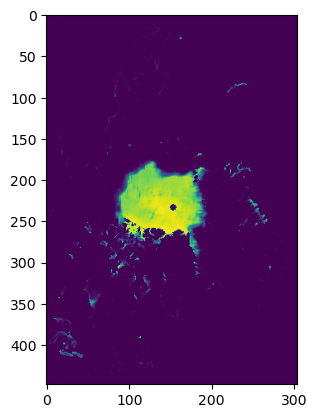

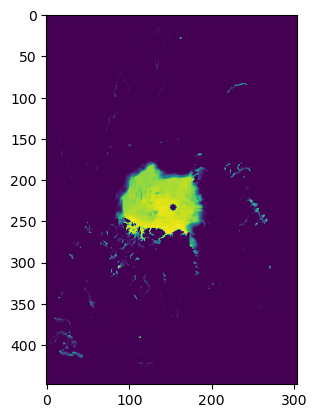

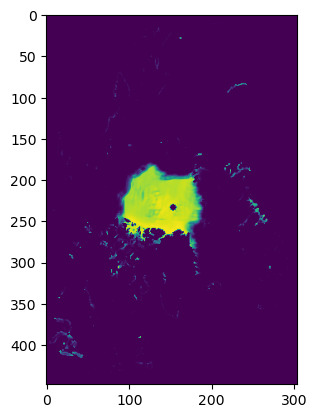

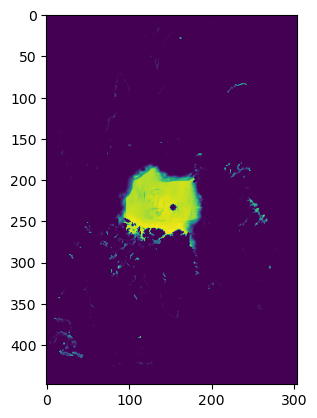

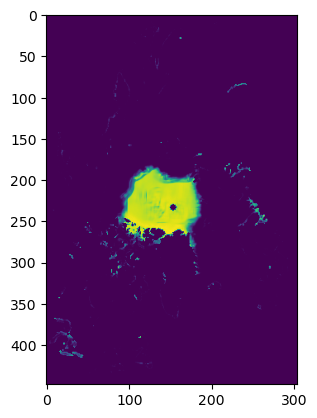

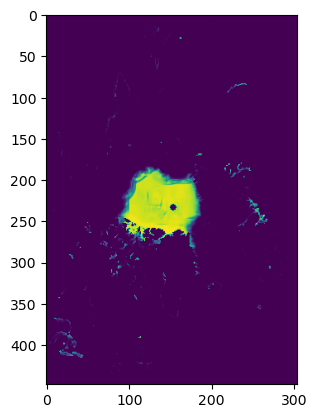

In [42]:
for i in range(12):
    plt.imshow(pred[i])
    plt.show()

## 제출

In [43]:
submission = pd.read_csv('data_v2/sample_submission.csv')

In [44]:
sub_2020 = submission.loc[:11, ['week_start']].copy()
sub_2021 = submission.loc[12:].copy()

sub_2020 = pd.concat([sub_2020, (pd.DataFrame(pred.reshape([12,-1])))], axis=1)
sub_2021.columns = sub_2020.columns
submission = pd.concat([sub_2020, sub_2021])

In [45]:
submission.to_csv('baseline.csv', index=False)